<a href="https://colab.research.google.com/github/podo47/DM_project/blob/main/DM_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')

from nltk.sentiment.vader import SentimentIntensityAnalyzer


from PIL import Image
import seaborn as sns
import re
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import chardet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Download dataset

## Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


## Unzip

In [ ]:
!unzip /content/dataset.zip -d /content/drive/MyDrive/Data_Mining #解壓縮

Archive:  /content/dataset.zip
  inflating: /content/drive/MyDrive/Data_Mining/covid19_tweets.csv  


In [ ]:
data_path = '/content/drive/MyDrive/Data_Mining/covid19_tweets.csv'
data = pd.read_csv(data_path)

In [ ]:
cm = sns.light_palette("green", as_cmap=True)
data.head(10).style.background_gradient(cmap=cm)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin it [̲̅$̲̅(̲̅ιοο̲̅)̲̅$̲̅] 👸🏻💚♊️🧀🌵🌃🌙,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",nan,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Author of Tough Sell: Fighting the Media War in Iraq. Bush Admin Alum. Newsmax Contributor. Fmr Exec Dir NYSGOP",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,nan,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Republican #Capitalist; Sports lover - #BBN #Cincinnati #Reds #Bengals #Trump2020,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs #Resist,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,"🖊️Official Twitter handle of Department of Information and Public Relations, Govt of Jammu & Kashmir",2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 @kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False
5,🎹 Franz Schubert,Новоро́ссия,"🎼 #Новоро́ссия #Novorossiya #оставайсядома #STAYatHOME Polymath, composer, English.",2018-03-19 16:29:52,1180,1071,1287,False,2020-07-25 12:27:06,#coronavirus #covid19 deaths continue to rise. It's almost as bad as it ever was. Politicians and businesses want… https://t.co/hXMHooXX2C,"['coronavirus', 'covid19']",Twitter Web App,False
6,hr bartender,"Gainesville, FL",Workplace tips and advice served up in a friendly place. Corporate blog of @ITMGroup by @Sharlyn_Lauby. Cheers!,2008-08-12 18:19:49,79956,54810,3801,False,2020-07-25 12:27:03,"How #COVID19 Will Change Work in General (and recruiting, specifically) via/ @ProactiveTalent #Recruiting… https://t.co/bjZxzGPMbK","['COVID19', 'Recruiting']",Buffer,False
7,Derbyshire LPC,nan,nan,2012-02-03 18:08:10,608,355,95,False,2020-07-25 12:27:00,You now have to wear face coverings when out shopping - this includes a visit to your local Community Pharmacy… https://t.co/OSu5Q4kdd7,nan,TweetDeck,False
8,Prathamesh Bendre,nan,"A poet, reiki practitioner and a student of law.",2015-04-25 08:15:41,25,29,18,False,2020-07-25 12:26:59,Praying for good health and recovery of @ChouhanShivraj . #covid19 #covidPositive,"['covid19', 'covidPositive']",Twitter for Android,False
9,Member of Christ 🇨🇳🇺🇸🇮🇳🇮🇩🇧🇷🇳🇬🇧🇩🇷🇺,👇🏻location at link below👇🏻,"Just as the body is one & has many members, & all the members of the body, though many, are one body, so it is with Christ. 1 Corinthians 12:12",2014-08-17 04:53:22,55201,34239,29802,False,2020-07-25 12:26:54,POPE AS GOD - Prophet Sadhu Sundar Selvaraj. Watch here at https://t.co/7X5RTyKVji #HurricaneHanna #COVID19… https://t.co/06dZcGUnwL,"['HurricaneHanna', 'COVID19']",Twitter for iPhone,False


# Data preprocessing

## Convert time stamps

In [ ]:
data['user_created'] = pd.to_datetime(data['user_created'])
data['created_year'] = data['user_created'].apply(lambda date : date.year)
data['created_month'] = data['user_created'].apply(lambda date : date.month)
data['created_day'] = data['user_created'].apply(lambda date : date.day)

data['date'] = pd.to_datetime(data['date'])
data['post_year'] = data['date'].apply(lambda date : date.year)
data['post_month'] = data['date'].apply(lambda date : date.month)
data['post_day'] = data['date'].apply(lambda date : date.day)

## Source

In [ ]:
source_list = data["source"].value_counts().index[0:10]

In [ ]:
data['source'] = data['source'].where(data['source'].isin(source_list), 'Others')

In [ ]:
data["source"].value_counts()

Twitter Web App        56891
Twitter for Android    40179
Twitter for iPhone     35472
Others                 18501
TweetDeck               8543
Hootsuite Inc.          7321
Twitter for iPad        4336
Buffer                  2728
Sprout Social           1833
Instagram               1759
IFTTT                   1545
Name: source, dtype: int64

## Data cleaning

Checking for nan

In [ ]:
nan = data.isnull().sum().sort_values(ascending=False)
nan

hashtags            51334
user_location       36771
user_description    10286
user_name               0
source                  0
post_month              0
post_year               0
created_day             0
created_month           0
created_year            0
is_retweet              0
text                    0
date                    0
user_verified           0
user_favourites         0
user_friends            0
user_followers          0
user_created            0
post_day                0
dtype: int64

In [ ]:
data['hashtags'].fillna('None', inplace=True)
data['user_location'].fillna('Unknown', inplace=True)
data['user_description'].fillna('Unknown', inplace=True)

## Extract country

<Axes: title={'center': 'Top 100 locations'}>

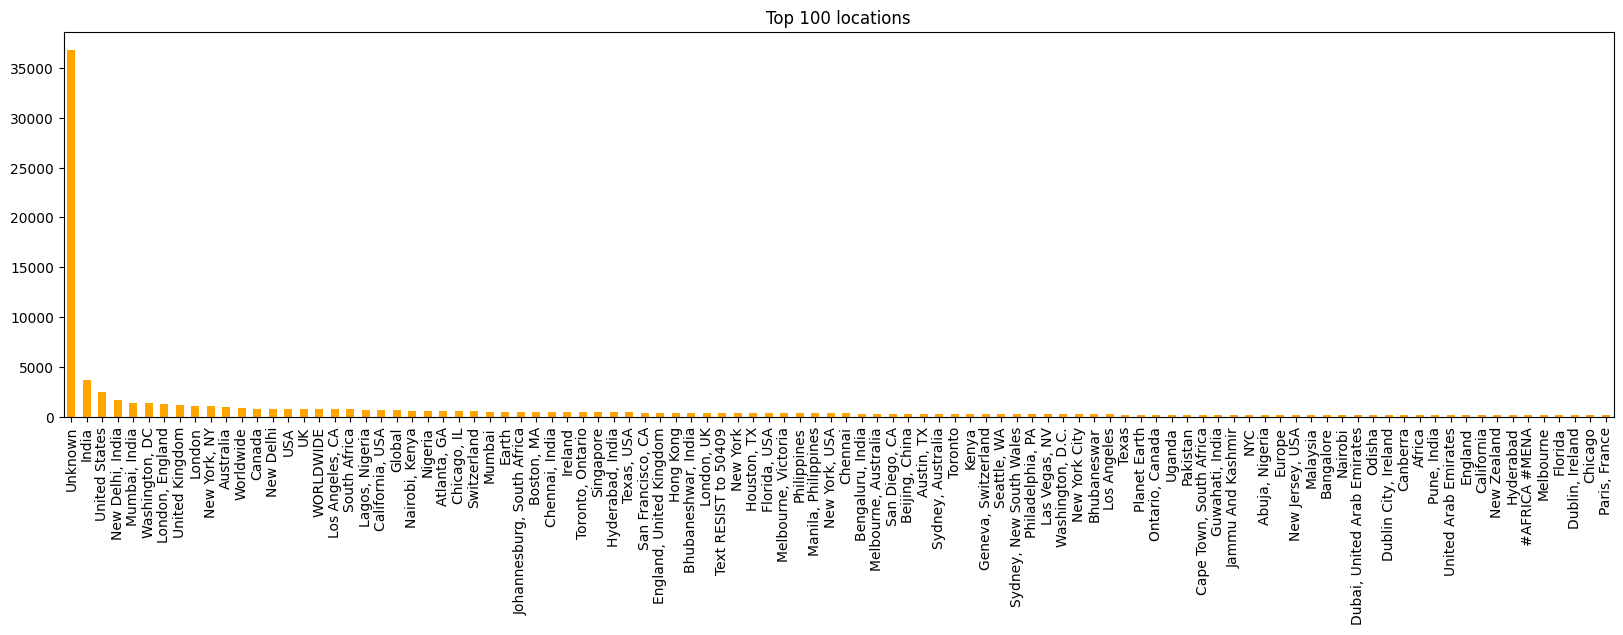

In [ ]:
data["user_location"].value_counts().head(100).plot.bar(title="Top 100 locations", figsize=(20, 5), color="orange")

Cleaning and Extracting country name from "user_ locations"

In [ ]:
# Splitting a string into 2 words, where the first word corresponds to city name and second word to the country name
# This acts only if the given str has a ',' in it else it would return the same
data['country'] = data['user_location'].apply(lambda x: x.split(",")[-1].strip() if ("," in x) else x)
data['city'] = data['user_location'].apply(lambda x: x.split(",")[0].strip() if ("," in x) else x)

# Replacing the two digit US city names with USA except UK and EU
data['country'] = data['country'].apply(lambda x: 'USA' if (len(x.lower().strip())<3) and ((x!='uk')|(x!='eu')) else x)
# Replacing lower case country names with standard ones
data['country'] = data['country'].apply(lambda x: 'USA' if x.lower().strip() in ("usa,united states,alabama, alaska, american samoa, arizona, arkansas, atlanta, california, colorado, connecticut, delaware, district of columbia, florida, georgia, guam, hawaii, idaho, illinois, indiana, iowa, kansas, kentucky, louisiana, maine, maryland, massachusetts, michigan, minnesota, mississippi, missouri, montana, nebraska, nevada, new hampshire, new jersey, new mexico, new york, north carolina, north dakota, northern mariana islands, ohio, oklahoma, oregon, pennsylvania, puerto rico, rhode island, south carolina, south dakota, tennessee, texas, u.s. virgin islands, utah, vermont, virginia, washington, west virginia, wisconsin, wyoming california, texas, usa,new york, us") else x)
data['country'] = data['country'].apply(lambda x: 'Canada' if x.lower().strip() in ("canada,ontario,toronto,quebec,montreal,quebec city,vancouver") else x)
data['country'] = data['country'].apply(lambda x: 'UK' if x.lower().strip() in ("united kingdom,london, england,uk, britain,great britain") else x)
data['country'] = data['country'].apply(lambda x: 'India' if x.lower().strip() in ("india,mumbai,tamil nadu,chennai,karnataka,bengaluru,kerala,thiruvanandhipuram,kochi,patna,delhi,new delhi,uttar pradesh,andhra pradesh,telengana,vishakapatinam,hyderabad,himachal pradesh,goa,jammu,jammu and kashmir,ladhak") else x)
data['country'] = data['country'].apply(lambda x: 'Unknown' if x.lower().strip() in ("worldwide, earth, global") else x)

In [ ]:
# If country name is found in city name
country_list = ['finland','netherlands','ireland','sweden','germany','denmark','switzerland','norway','france','spain','canada','bulgaria','belgium',
                'estonia','luxembourg','newzealand','austria','italy','australia','latvia','cyprus','singapore','japan',
                'northmacedonia','southkorea','moldova','slovakia','romania','portugal','poland','czechrepublic','slovenia','costarica',
                'chile','iceland','lithuania','georgia','hungary','russia','greece','malaysia','armenia','southafrica']

def checker(x):
    # Checking for city names in country list
    if x['city'].lower().strip() in country_list:
        # If city name is not same as country name but is in country list
        if x['city'].lower().strip() != x['country'].lower().strip():
            return x['city']
        else:
            return x['country']
    else:
        return x['country']

data['country'] = data[['city','country']].apply(checker,axis=1)

In [ ]:
country_count = data["country"].value_counts()

In [ ]:
data = data.groupby('country').filter(lambda x: country_count[x.name] > 500)

In [ ]:
data["country"].value_counts()

USA             52806
Unknown         40013
UK               7351
India            3892
Canada           3778
Australia        2170
Nigeria          2082
South Africa     2019
Ireland          1242
Kenya            1088
Switzerland       967
Philippines       908
Pakistan          602
Singapore         510
Name: country, dtype: int64

In [ ]:
location_count = pd.DataFrame(data['country'].value_counts())
location_count.reset_index(inplace=True)
location_count = location_count.set_axis(['Country', 'Count'], axis=1)
country_fig = px.bar(x='Country',y='Count',data_frame=location_count,color='Country',
                    labels={'x':'Countries','y':'Counts'},title="Country Distribution (counts more than 500)", hover_data=['Count'])
country_fig.update_layout(title_font=dict(size=30))

## Drop useless features

In [ ]:
data.drop(['user_location'], axis=1, inplace=True)
data.drop(['user_created'], axis=1, inplace=True)
data.drop(['date'], axis=1, inplace=True)
data.drop(['post_year'], axis=1, inplace=True)
data.drop(['city'], axis=1, inplace=True)
data.drop(['is_retweet'], axis=1, inplace=True)

In [ ]:
data.dtypes

user_name           object
user_description    object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
text                object
hashtags            object
source              object
created_year         int64
created_month        int64
created_day          int64
post_month           int64
post_day             int64
country             object
dtype: object

## Save modified data

In [ ]:
data.to_hdf("/content/drive/MyDrive/Data_Mining/data_fixed.h5", index = False, key='data')

# EDA

## Load modified data

In [ ]:
mdata_path = "/content/drive/MyDrive/Data_Mining/data_fixed.h5"
mdata = pd.read_hdf(mdata_path, key='data')

## Users' Follower, Friends and Favourites

In [ ]:
mdata[['user_followers','user_friends','user_favourites']].describe()

,user_followers,user_friends,user_favourites
count,1.194280e+05,119428.000000,1.194280e+05
mean,1.273169e+05,2017.026828,1.343206e+04
std,8.855199e+05,7894.403447,4.531294e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.290000e+02,124.000000,1.520000e+02
50%,7.650000e+02,482.000000,1.482000e+03
75%,4.723000e+03,1568.000000,8.156250e+03
max,4.944256e+07,437666.000000,2.047197e+06


In [ ]:
box_fig = make_subplots(rows=3, cols=1)
box_fig.add_trace(go.Box(x=mdata['user_followers'],name='user_followers'), row=1, col=1)
box_fig.add_trace(go.Box(x=mdata['user_friends'],name='user_friends'), row=2, col=1)
box_fig.add_trace(go.Box(x=mdata['user_favourites'],name='user_favourites'), row=3, col=1)
box_fig.update_layout(title="Boxplot of Users' Follower, Friends and Favourites")
box_fig.update_layout(title_font=dict(size=30))

## Source

In [ ]:
source_count = pd.DataFrame(mdata['source'].value_counts())
source_count.reset_index(inplace=True)
source_count = source_count.set_axis(['Source', 'Count'], axis=1)
source_fig = px.pie(source_count, values='Count', names='Source', title="Pie Chart of Source", width=800, height=600)
source_fig.update_traces(textposition='outside', textinfo='percent+label')
source_fig.update_layout(title_font=dict(size=30))

## User's Verification Status

In [ ]:
verify_count = pd.DataFrame(mdata['user_verified'].value_counts())
verify_count.reset_index(inplace=True)
verify_count = verify_count.set_axis(['Verify', 'Count'], axis=1)
verify_fig = px.bar(x='Verify',y='Count',data_frame=verify_count,color='Verify',
                    labels={'x':'Verify','y':'Counts'},title="Bar Plot of User's Verification Status",width=800, height=600,text_auto='.2s')
verify_fig.update_layout(title_font=dict(size=30))
verify_fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)